In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from statistics import variance
from scipy.stats import skew
from scipy.stats import kurtosis
from IPython.display import display

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline


In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')
train_labels = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv')

In [4]:
sensors = [col for col in train.columns if 'sensor_' in col]
train_pivot = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)

# Feature Engineering and Selection
1. Each sequence has 13 sensors measured by 60 steps. There is a distribution within each sensor.
2. The parameters to characterize a distribution are distribution center, quantifying variability, standard deviation and variance, skewness and kurtosis.
3. Based on each distribution, the new features of mean, standard deviation, max, min, skewness and kurtosis can be engineered.

In [5]:
def feature_engineer(df):
    df_engineer = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        df_engineer[sensor+'_mean'] = df[sensor].mean(axis=1)
        df_engineer[sensor+'_min'] = df[sensor].min(axis=1)
        df_engineer[sensor+'_max'] = df[sensor].max(axis=1)
        df_engineer[sensor+'_std'] = df[sensor].std(axis=1)
        df_engineer[sensor+'_skew'] = df[sensor].skew(axis=1)
        df_engineer[sensor+'_kurtosis'] = df[sensor].kurtosis(axis=1)
    return df_engineer    

train_transformed = feature_engineer(train_pivot)

## Low-Variance Features
1. low variance featues has similar values across different observations. They provide little information to predict the target variables.
2. Half of features' variances below ~10. 

Variance for each feature. 

 count      78.000000
mean      198.973018
std       817.094526
min         0.002058
25%         0.902145
50%        10.999658
75%        62.251135
max      5154.228771
dtype: float64


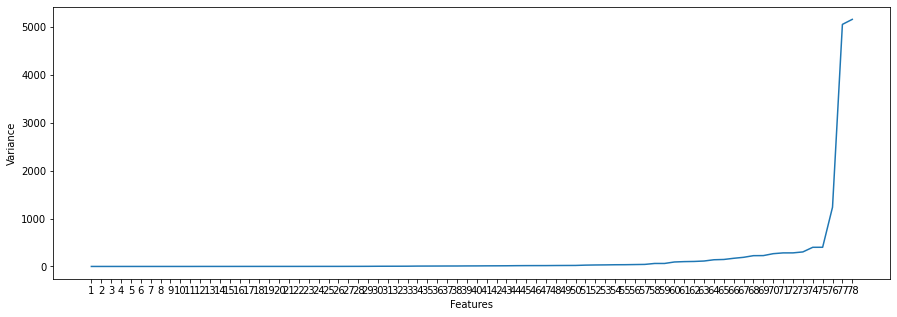

In [6]:
feature_variance = train_transformed.var()
print("Variance for each feature.", "\n\n", feature_variance.describe())
plt.figure(figsize=(15,5))
plt.plot(train_transformed.var().sort_values())
plt.xticks(ticks=np.arange(0,len(feature_variance)), labels=np.arange(1,len(feature_variance)+1))
plt.xlabel("Features")
plt.ylabel('Variance')
plt.show()

In [7]:
features_del = feature_variance[feature_variance <= 10].index

train_transformed.drop(columns=features_del, inplace=True)

A good method to visualize feature dependency.

To visualize how each engineered feature affects the target variables, each feature is built corresponding to target state. then the feature is sorted from small to largest and we visualize trend of the 1000-rolling mean. If the target variable responds to any feature, the line should not be a horizontal line.  

We can filter out some non-relevant feature by visualization

In [8]:
train = train_transformed.join(train_labels, on='sequence').drop(columns='sequence')

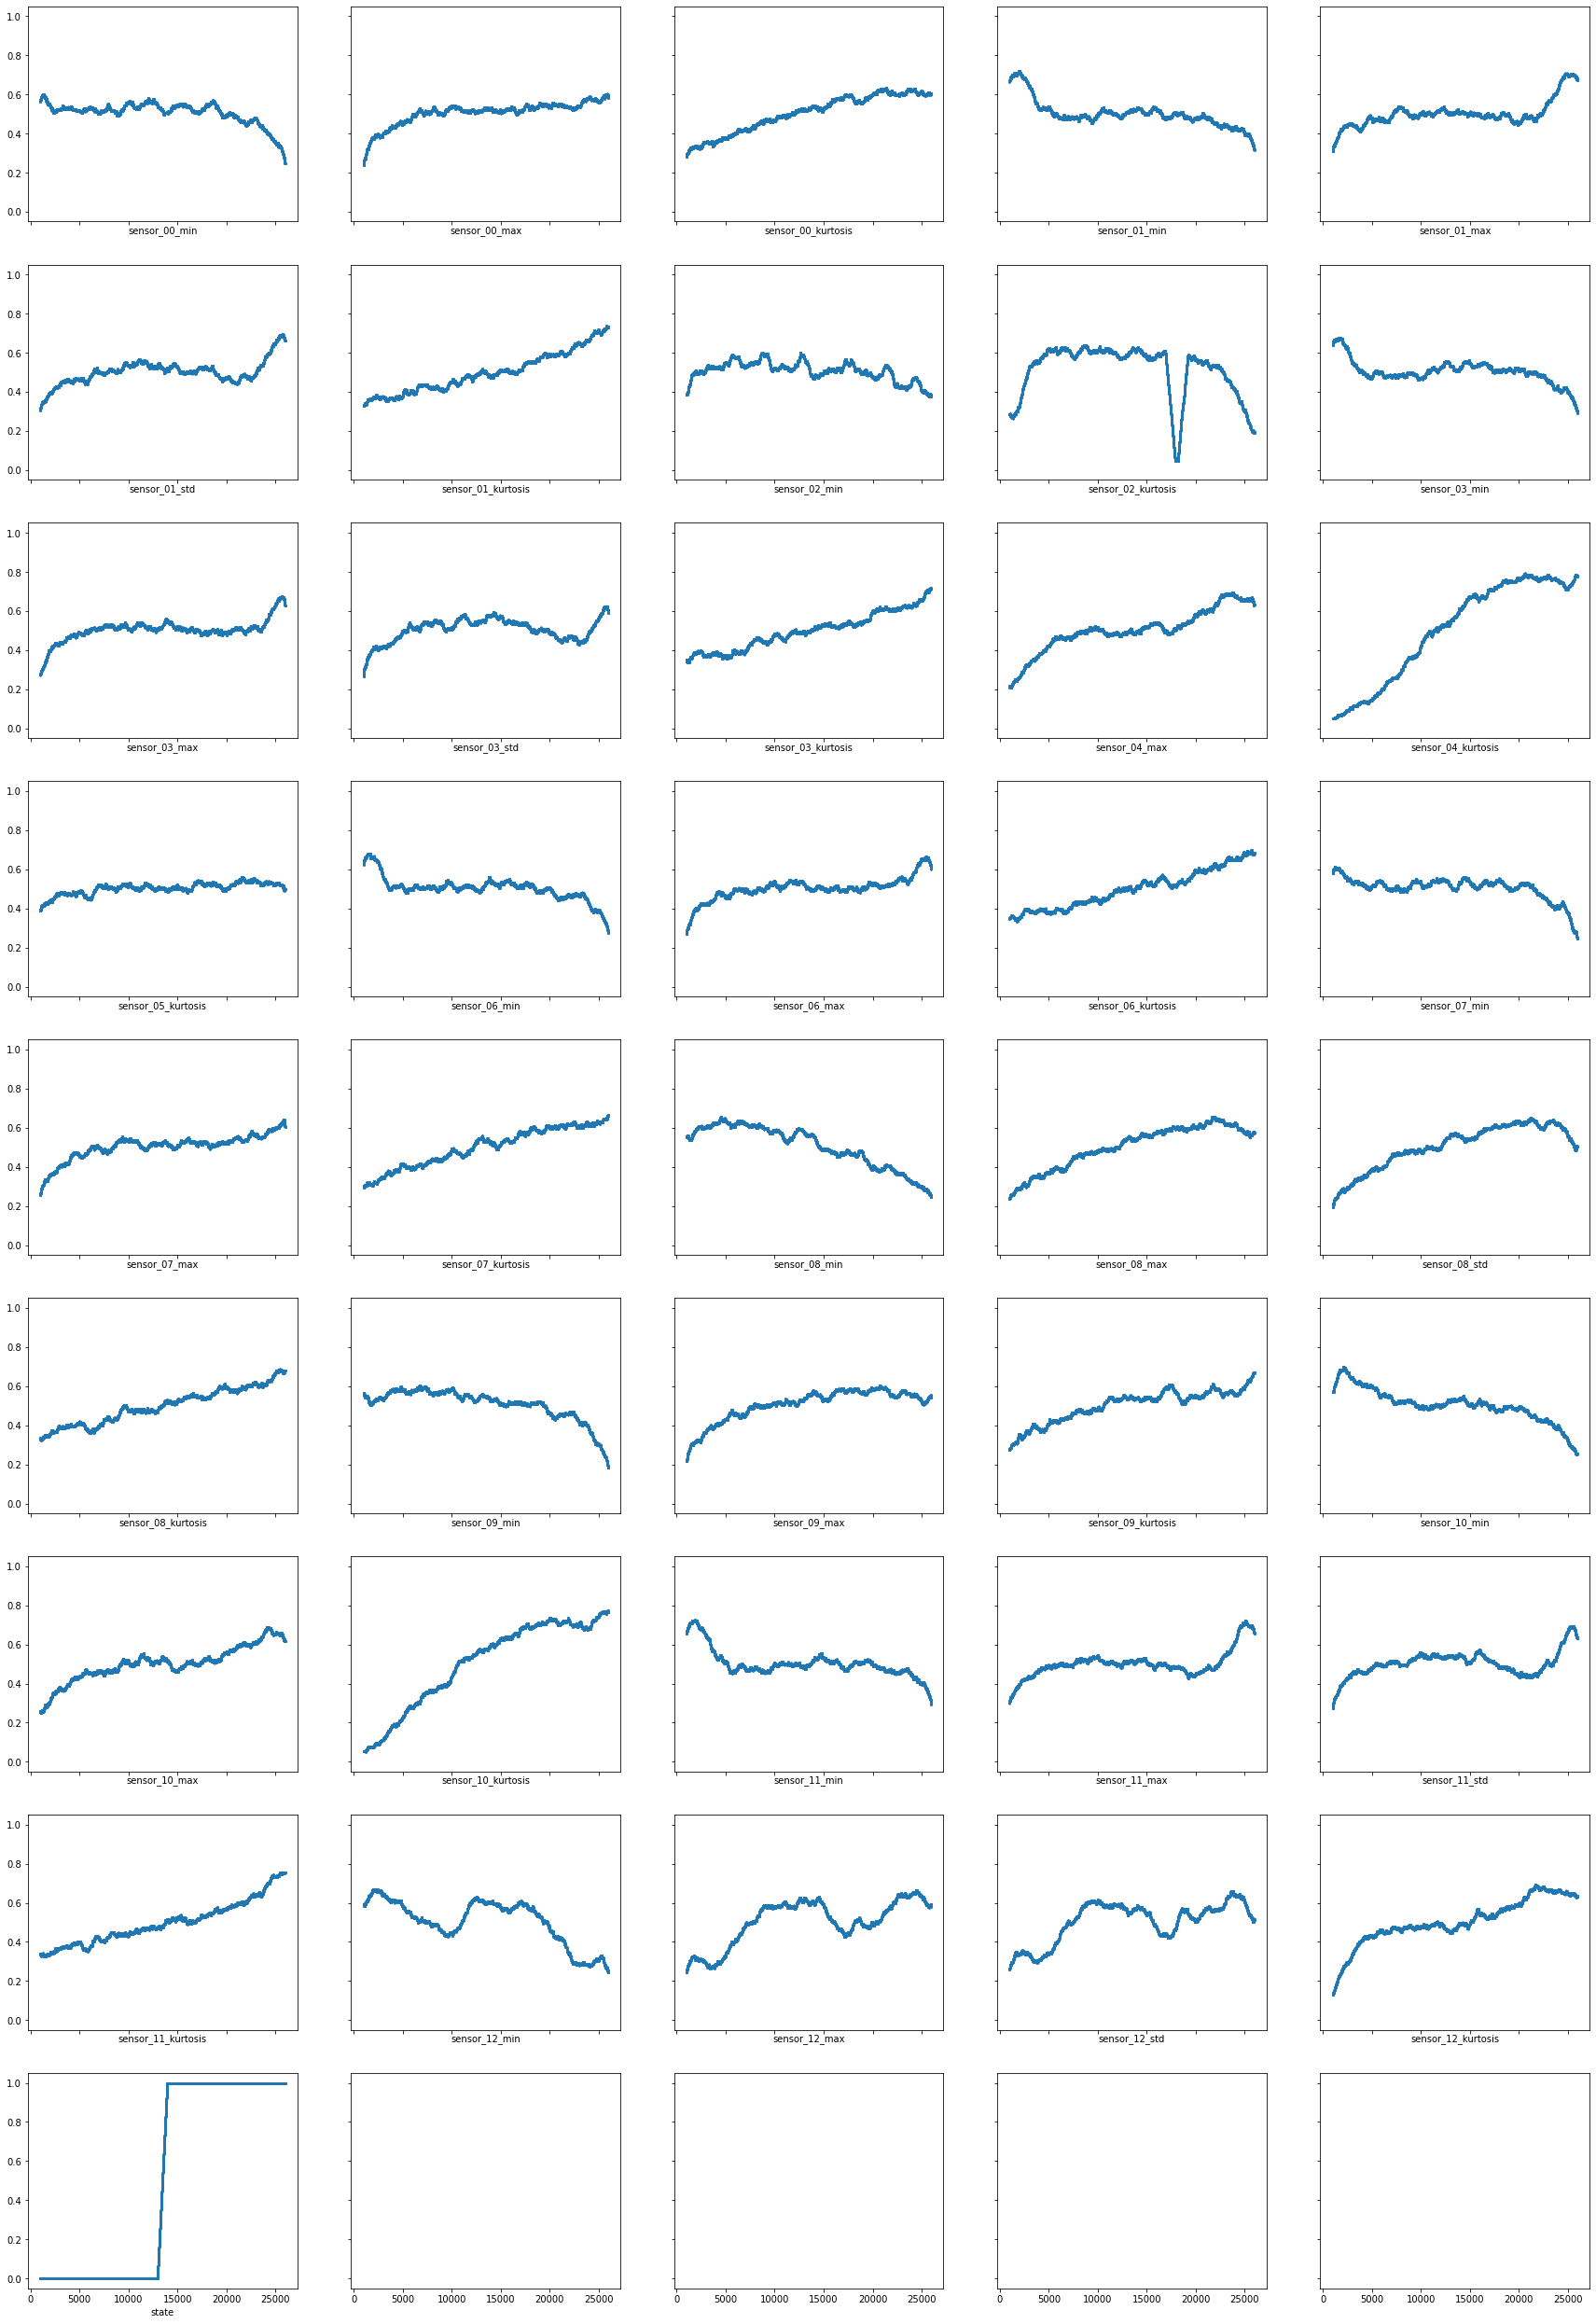

In [9]:
plt.subplots(9, 5, sharey=True, sharex=True, figsize=(30, 45))
for i, col in enumerate(train):
    temp = pd.DataFrame({col:train[col].values, 'state': train.state.values})
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(9, 5, i+1)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
plt.show()    

## Univariate Feature Selection
Univariate feature selection works by selecting the best features based on univariate statistical test. 

For classification, the scoring functions can be chi2, f_classif, mutual_info_classif



In [10]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
X, y = train.iloc[:, :-1], train.iloc[:,-1]

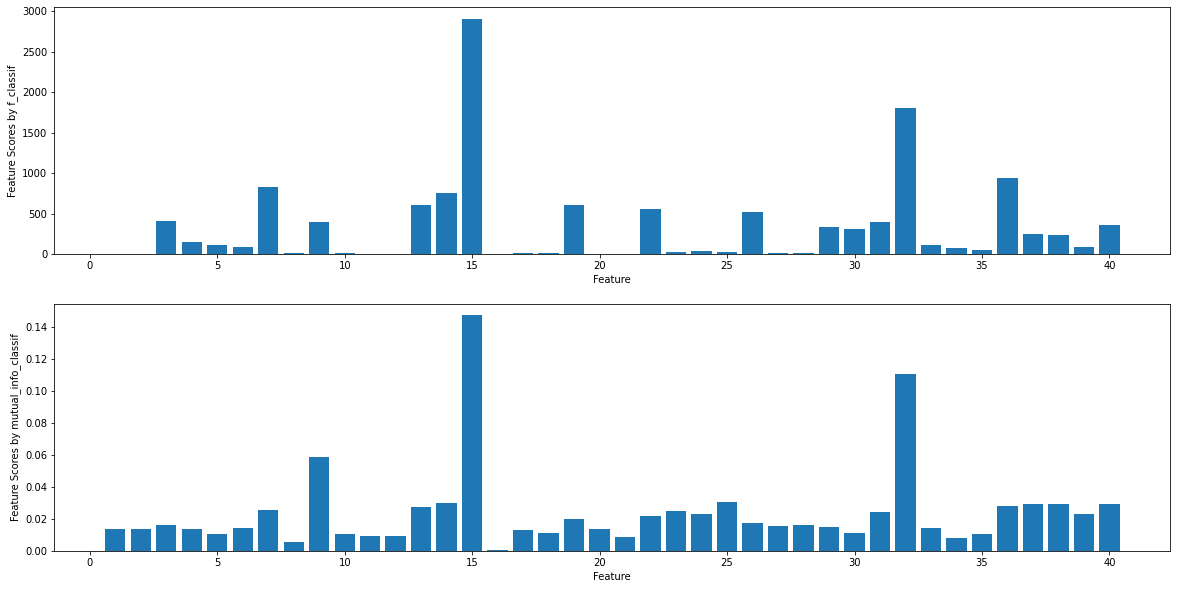

In [27]:
# Comparison of different scoring function
fig, axes = plt.subplots(2,1, figsize=(20, 10))
for ax, func in zip(axes, [f_classif, mutual_info_classif]):
    selector = SelectKBest(func)
    selector.fit(X,y)
    scores = selector.scores_
    ax.bar(np.arange(1, len(scores)+1), scores)
    ax.set_xlabel("Feature")
    ax.set_ylabel(f"Feature Scores by {func.__name__}")
plt.show()


In [42]:
# feature selection by function of f_classif
# p values of 0.05 as significance level
selector = SelectKBest(f_classif)
selector.fit(X, y)
df_pvalues = pd.DataFrame({"features": selector.feature_names_in_, "pvalues": selector.pvalues_})
feature_del2 = df_pvalues[df_pvalues.pvalues>=0.05].features


In [ ]:
train.drop(columns=feature_del2, inplace=True)
train.shape

,,sensor_00_max,sensor_00_kurtosis,sensor_01_min,sensor_01_max,sensor_01_std,sensor_01_kurtosis,sensor_02_min,sensor_02_kurtosis,sensor_03_min,sensor_03_max,...,sensor_10_kurtosis,sensor_11_min,sensor_11_max,sensor_11_std,sensor_11_kurtosis,sensor_12_min,sensor_12_max,sensor_12_std,sensor_12_kurtosis,state
sequence,subject,,,,,,,,,,,,,,,,,,,,,
0,47,7.534003,15.789452,-3.002101,3.623950,1.509221,0.307700,0.666667,-0.013147,-3.163717,5.712389,...,-0.452232,-2.972222,2.989712,1.257716,0.093245,-50.658994,6.674766,8.206880,23.278702,0
1,66,5.870943,7.437864,-2.745798,2.525210,0.949403,1.162802,-2.647306,-0.940112,-4.506195,5.637168,...,21.845876,-3.573045,8.044239,1.774826,6.265236,-160.234442,144.598039,50.291288,3.469696,1
2,66,3.402628,0.877085,-1.733193,2.321429,0.803884,0.862391,-1.332820,0.604058,-1.751327,2.827434,...,8.148263,-1.705761,1.475309,0.611138,0.641304,-1.044331,1.116795,0.361055,2.215110,1
3,542,4.856260,0.141924,-5.860294,6.722689,1.914868,3.785128,0.333847,-0.179418,-5.076991,5.435398,...,4.347234,-3.837449,3.593621,1.399494,0.870465,-0.837170,0.593350,0.241708,2.417960,1
4,437,5.455951,0.709014,-5.898109,3.532563,1.385251,5.014997,0.666667,-0.766204,-5.426549,3.365487,...,-1.208702,-7.439300,6.989712,2.894626,0.424942,-0.098465,0.135976,0.051600,0.105810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,558,3.974498,0.517564,-4.287815,4.161765,1.985067,-0.796106,-0.332820,-0.861341,-5.743363,5.553982,...,2.389686,-6.088477,11.134774,3.266255,1.326447,-0.262575,0.297954,0.096523,1.525881,1
25964,297,2.927357,10.331569,-3.253151,2.758403,0.962603,2.210461,-0.666153,-1.113487,-1.182301,1.639823,...,-1.281020,-2.101852,2.559671,0.829925,1.169478,-37.633845,40.998295,18.435077,-0.604172,0
25965,129,2.818393,0.576470,-2.378151,3.826681,1.317566,-0.131857,-0.999486,-0.728099,-2.559292,1.830973,...,-0.728413,-2.271605,2.876543,1.310547,-0.672143,-2.837170,2.394714,1.014761,0.373490,1


Automatical feature selection by gradient boost which select features from zero and add feature one by one

In [52]:
# Sequential feature selection
estimator = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25, max_iter=1000, 
                                          min_samples_leaf=500, l2_regularization=1, max_bins=255,
                                          random_state=4, verbose=0)
X, y = train.iloc[:, :-1], train.iloc[:,-1]
n_iterations, backward = 37, False

In [ ]:
# an example code to build sequential feature selector
if n_iterations != 0:
    n_features = X.shape[1]
    current_mask = np.zeros(shape=n_features, dtype=bool)
    history = []
    for _ in range(n_iterations):
        candidate_feature_indices = np.arange(len(current_mask))
        scores = {}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            X_new = X.values[:, ~candidate_mask if backward else candidate_mask]
            scores[feature_idx] = cross_val_score(estimator, X_new, y, cv=GroupKFold(n_splits=5),
                                                 groups=train.index.get_level_values("subject"),
                                                 scoring='roc_auc', n_jobs=-1
                                                 ).mean()
        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])
        current_mask[new_feature_idx] = True
        history.append(scores[new_feature_idx])
        new = 'Deleted' if backward else 'Added'
        print(f'{new} feature: {str(X.columns[new_feature_idx]):30}'
              f'{scores[new_feature_idx]:.3f}')
    
    print()
    plt.figure(figsize=(12,6))
    plt.scatter(np.arange(len(history))+1, history)
    plt.ylabel('AUC')
    plt.xlabel('Features removed' if backward else 'Features added')
    plt.title('Sequential Feature Selection')
    plt.show()
    
        
        

Added feature: sensor_04_kurtosis            0.787
Added feature: sensor_10_kurtosis            0.805
Added feature: sensor_12_min                 0.814
Added feature: sensor_10_min                 0.825
Added feature: sensor_08_std                 0.832
Added feature: sensor_12_kurtosis            0.837
Added feature: sensor_02_kurtosis            0.842
Added feature: sensor_02_min                 0.846
Added feature: sensor_09_max                 0.850
Added feature: sensor_00_kurtosis            0.853
Added feature: sensor_04_max                 0.855
Added feature: sensor_07_kurtosis            0.857
Added feature: sensor_07_max                 0.858
Added feature: sensor_09_kurtosis            0.860
Added feature: sensor_08_kurtosis            0.860
Added feature: sensor_01_std                 0.861
Added feature: sensor_01_kurtosis            0.862


In [ ]:
train_pivot['sensor_01'].aggregate([np.mean, max, min], axis=1)

In [ ]:
train_pivot['sensor_00'].agg([skew, kurtosis], axis=1)